# Data Wrangling on OpenStreetMaps

A part of the requirements of this project is to process an OpenStreetMaps region of at least 50 MB (uncompressed) data. The use of a smaller extract of the selected region is suggested for testing.

In this project we're going to deal with OpenStreetMap data of Berlin, Germany.
Two regions were used:

* A custom crop of the Berlin city area:
    * Region: `52.3319824..52.6797125 N`, `13.0709838..13.7741088 E` ([OSM](http://www.openstreetmap.org/#map=11/52.5062/13.4222)).
    * `101 MB` compressed, `1.4 GB` decompressed XML, and
* A smaller sample of the Mitte district of Berlin:
    * Region: `52.52912..52.53794 N`, `13.39977..13.40550 E` ([OSM](http://www.openstreetmap.org/#map=17/52.53110/13.40201)).
    * `148 KB` compressed, `1.9 MB` decompressed XML.
    
To get a feeling of the area, here's a map of [Berlin districts](https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin):

![](assets/district-map.png)
    
We can query the files directly for their size and find that the Berlin Mitte extract is indeed 1.9 MB (uncompressed) XML:

In [1]:
import os
def file_size(path: str, scale: float=1024*1024):
    return os.path.getsize(path) / scale
file_size('osm-extracts/berlin-mitte.osm')

1.9322547912597656

The "full" Berlin extracts are 1.4 GB (uncompressed) and 101 MB (compressed) respectively:

In [2]:
file_size('osm-extracts/berlin.osm'), file_size('osm-extracts/berlin.osm.bz2')

(1448.0486783981323, 101.01312637329102)

The data was obtained by querying the OpenStreetMaps Overpass API's XAPI wrapper at `http://www.overpass-api.de/api/xapi` using the following parameters:

- `*[bbox=13.39977,52.52912,13.40550,52.53794][@meta]`
- `*[bbox=13.0709838,52.3319824,13.7741088,52.6797125][@meta][@timeout=3600]`

Specifically for the whole Berlin area a `timeout` of one hour was used. Data can be downloaded using e.g. `wget` using a command like the following:

```bash
wget -O berlin-mitte.osm 'http://www.overpass-api.de/api/xapi?*[bbox=13.39977,52.52912,13.40550,52.53794][@meta]'
```

The file `find_tags.py` scans the OSM XML file for XML tags in use and prints them to the standard output. Running

```bash
python find_tags.py osm-extracts/berlin.xml.bz2
```

gives the following result:

```
         1 osm
    935054 osm.way
         1 osm.note
         1 osm.meta
   6007591 osm.node
   7429706 osm.way.nd
   2738476 osm.way.tag
   3215139 osm.node.tag
     14715 osm.relation
     78089 osm.relation.tag
    325599 osm.relation.member
```

We correctly find one `osm` tag (the root element), as well as one `note` and `meta` element describing the data. We also see 6007591 `node` elements, 935054 `way` elements, as well as 14715 `relation` entries. We will obtain the same numbers later by querying the database.

Another file, `find_tag_keys.py` obtains all `tag` key attributes in order to get an overview of the actual data (apart from geocoordinates). An excerpt from the output is

```
         2 abandoned:place
        46 access
      1004 addr:city
       966 addr:country
         2 addr:flats
         2 addr:housename
      1030 addr:housenumber
         4 addr:inclusion
      1010 addr:postcode
      1027 addr:street
       970 addr:suburb
...
       317 wheelchair
         8 wheelchair:description
        23 wikidata
        19 wikipedia
         2 workrules
```

however the whole list is too long to replicate in this document.

## Automatic auditing of errors

Rather than converting the OSM XML file to actual JSON first in order to then import it to MongoDB, the data was converted to BSON directly and inserted to MongoDB on the fly while parsing the file. This is implemented in `import.py`, which makes use of an auditing pipeline for automated data cleaning. Since we're going to be dealing with street information in this project, the chosen automatic correction is related to street names.

A common theme in street names in Germany is the relation of streets to locations and people, suffixed by the type of the street. For a location - e.g. a city - the name is composed by the location name suffixed by `e` or `er`, followed by a blank, followed by the street type; an example of this would be `Französische Straße`, which is a street related to France. For a person, the persons name is directly composed with the street type; `Einsteinstraße` would be an example for this. However, the opposite need not be true: While the name `Derfflingerstraße` suggests a place called `Derffling` (which doesn't exist) due to suffix `er`, it is actually about [Georg von Derfflinger](https://en.wikipedia.org/wiki/Georg_von_Derfflinger). Lastly, the word `Straße` is usually abbreviated with `Str.`.

Common errors in street names are the use of an extra gap, e.g. `Einstein Straße`, missing dashes (e.g. `Ernst Zinna Weg` instead of `Ernst-Zinna-Weg`), or missing letters (`...staße` instead of `...straße`). In

```
./data_wrangling/auditing/streets.py
```

the cleaning of street names is implemented using a mixture of simple heuristics, regular expressions and a known stoplist. Initial simple assumption about the nature of street names quickly proved to be naive, leading to more and more additions to the ruleset. Occurrences of the `Str.` abbreviation are normalized to the full word, `Straße`. The files `collect_street_names.py` and `test_street_names.py` were implemented to validate the rules and assumptions. Here's an output of the automatic auditing:

```
  Skipped "Allee der Kosmonauten/ Märkische Allee": Not a street.
Corrected "Bergstrasse" to "Bergstraße".
Corrected "Blankenfelder Str." to "Blankenfelder Straße".
  Skipped "Eichner Grenzweg/Ahrensfelder Chaussee": Not a street.
Corrected "Ernst Zinna Weg" to "Ernst-Zinna-Weg".
Corrected "Stadtrandstaße" to "Stadtrandstraße".
Corrected "Strandpromedade" to "Strandpromenade".
  Skipped "U-Bahnhof Alt-Tempelhof": Not a street.
Corrected "Waterloo Ufer" to "Waterloo-Ufer".
```

For uncorrectable cases such as `Allee der Kosmonauten/ Märkische Allee`, which is a crossroad, the tag in question was removed altogether in `import.py`. Street names as referenced in train stations (e.g. `S+U Bornholmer Str.`) were not addressed, since these occurrences need not necessarily reference a street, but could also relate to crossroads, parks or suburbs in general.

Additional audit actions can be added by subclassing the `AuditTag` class defined in 


```
./data_wrangling/auditing/AuditTag.py
```

and adding them to the `audit_pipeline` array in `import.py`. Only a single audit step was added there for the scope of this project in order to show understanding of the concept. Re-importing (parts of) the data over and over is a time consuming effort, especially in the presence of errors that only occur rarely. Instead, it was opted for importing the data first, then fixing occurrences of errors directly in the database later, should they appear. Adding another audit step to address these in future imports is then an easy task.

## Querying the database

Let's now have a look at the imported dataset by obtaining a database connection to the MongoDB server.
Using [Docker](https://www.docker.com/) and [Docker Compose](https://docs.docker.com/compose/), a working database instance can be quickly spun up by calling 

```bash
docker-compose up
```

in the project's directory. After the database instance is started (and the data is imported using `import.py`), we can connect to the database collection and query it.

In [3]:
%load_ext autoreload
%autoreload 2

import pymongo
connection = pymongo.MongoClient('mongodb://localhost/dand')
berlin = connection.get_default_database().get_collection('osm_berlin')

Let's determine the number of distinct users who contributed to the map region:

In [4]:
distinct_users = berlin.distinct('user.name')
print(len(distinct_users))

6622


There are about 6.6k user names; if everything is correct, there should be as many user IDs as there are users:

In [5]:
print(len(berlin.distinct('user.id')))

6622


We find that the numbers are consistent. Here is a random sample of `10` user names from the previously loaded list:

In [6]:
import random
print('- ' + '\n- '.join(random.choices(distinct_users, k=10)))

- Markus W
- MapperJannis
- seawolff
- franzi_is24
- HellSpawn
- gerdwander
- Martin Berlin
- Marvin1998
- Anfänger-Eva
- empty


We now import our queries.

In [119]:
from data_wrangling.queries import *

Since the data model in MongoDB follows the original XML structure where possible, we can easily query for the different number of "top-level" tags, concretely `node`, `way` and `relation`. We can make use of the MongoDB aggregation pipeline, specifically its `$group` operator.

In [8]:
print(get_tag_types(berlin))

relation : 14715
way      : 935054
node     : 6007591


We find that we have about 6 million `node`s, 0.9 million `way`s and about 15k `relation`s stored; these are the numbers we previously found by scanning the OSM XML file directly.
Alternatively, we could have used the regular `.find()` function with `.count()`.

In [24]:
count_elems(berlin, 'node')

6007591

We can also query for `tag` values directly. Let's investigate how many public telephones ([amenity=telephone](https://wiki.openstreetmap.org/wiki/Tag:amenity=telephone)) we find in the region:

In [25]:
count_tags(berlin, 'tags.amenity', 'telephone')

1327

As it turns out, there are about 1.3k public telephones mapped. Here's the location of the first match:

In [11]:
berlin.find_one({'tags.amenity': 'telephone'}, 
                {'loc.coordinates': 1, '_id': 0})

{'loc': {'coordinates': [13.4054777, 52.5374226]}}

The coordinate of 52.537 degree latitude and 13.405 degree longitude corresponds to [this location](https://www.openstreetmap.de/karte.html?zoom=19&lat=52.5374&lon=13.40542&layers=B000TT) on the map.

<br/>

![](assets/telephone_cell.jpg)

<br/>

Using that location we can now look up the closest house address and obtain the distance to it in meters, again using the aggregation pipeline and its `$geoNear` operator:

In [28]:
get_closest_address(berlin, [13.4054777, 52.5374226])

{'addr': {'house_no': '238', 'street': 'Schwedter Straße'},
 'coordinates': [13.4056601, 52.5371603],
 'distance_meters': 31.66807964339603}

From the image (and map) we can see that the returned answer, `Schwedter Straße 238` ([map](https://www.openstreetmap.de/karte.html?zoom=19&lat=52.5371603&lon=13.4056601&layers=B000TT)), seems correct and the distance is plausible.

As already established, not all data was cleaned automatically during import. Querying for the set of suburb names used in addresses gives an example for incorrect data. Here's the first ten suburb names as returned from the query:

In [13]:
distinct_suburbs = berlin.distinct('tags.addr:suburb')
distinct_suburbs[:10]

['Mitte',
 'Prenzlauer Berg',
 'Tiergarten',
 'Charlottenburg',
 'Moabit',
 'Halensee',
 'Nikolassee',
 'Hansaviertel',
 'Bohnsdorf',
 'Spandau']

All of them are correct. An instance of an incorrectly spelled suburb is the occurrence of `Bergholz-Rebrücke` (which is missing an `h`) alongside the correctly spelled variant ([`Bergholz-Rehbrücke`](https://de.wikipedia.org/wiki/Bergholz-Rehbr%C3%BCcke)):

In [14]:
[s for s in distinct_suburbs if s.startswith('Bergholz')]

['Bergholz-Rehbrücke', 'Bergholz-Rebrücke']

This showcases another problem of the extracted map region: Due to its rectangular nature it also contains regions from outside Berlin; in this case, the suburb is really related to the city of Potsdam.

# Street types

Let's see how many streets are dedicated to a person:

In [41]:
count_street_types_by_suffix(berlin, 'straße')

171304

Let's see how many streets are related to a place by looking at streets ending in ` Straße` or `-Straße`:

In [42]:
count_street_types_by_regex(berlin, '-?Straße$')

110362

We can now ask the question for the streets in each district. Right now this needs to be done using the `node` elements since `way` elements only hold ID references. This can be simplified by duplicating coordinate information of `node`s in `way`s and indexing the paths as either lines or closed polygons, depending on the `way` type.

In [52]:
from supplemental import get_district_geojson
district_bounds = get_district_geojson()
streets = get_streets_per_district(berlin, district_bounds)

Finding streets in Charlottenburg-Wilmersdorf ...
Finding streets in Friedrichshain-Kreuzberg ...
Finding streets in Lichtenberg ...
Finding streets in Marzahn-Hellersdorf ...
Finding streets in Mitte ...
Finding streets in Neukölln ...
Finding streets in Pankow ...
Finding streets in Reinickendorf ...
Finding streets in Spandau ...
Finding streets in Steglitz-Zehlendorf ...
Finding streets in Tempelhof-Schöneberg ...
Finding streets in Treptow-Köpenick ...


Here's a sample of street names in Berlin Mitte:

In [53]:
streets['Mitte'][:10]

['Ackerstraße',
 'Adalbertstraße',
 'Adele-Schreiber-Krieger-Straße',
 'Adolfstraße',
 'Afrikanische Straße',
 'Agricolastraße',
 'Albrechtstraße',
 'Alex-Wedding-Straße',
 'Alexanderplatz',
 'Alexanderstraße']

Since the districts vary in size by a big amount, we can now weigh the results by the respective area of the district, giving us the number of streets per unit area. Here's the calculated area of [Berlin Mitte](https://en.wikipedia.org/wiki/Mitte), which should be approximately 39.5 km².

In [56]:
areas = get_district_areas(district_bounds, 0.001)
areas['Mitte']

39.31388700279854

When we plot the number of streets against the district area of each district, we find an interesting correlation:

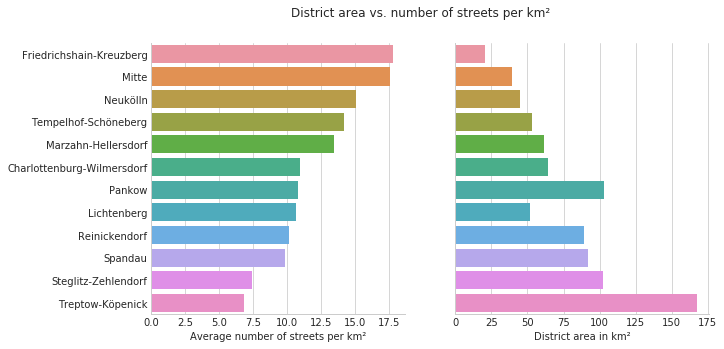

In [100]:
from data_wrangling.plots import *
%matplotlib inline
plot_street_counts(streets, areas)

We find that the inner districts of Berlin have a much denser net of streets, whereas the bigger outer districts have only as few as 1/3rd of the number of streets of the smallest district. A notable exception is the district of Pankow, which only recently was fused from three former districts, Pankow, Prenzlauer Berg and Weißensee, the latter of which contributes to the size most.

We can now have a look at the distribution of streets dedicated to places and persons. Since there is a plethora of different street suffixes, such as `Weg` (way) or `Allee` (avenue), `Platz` (place) etc., we'll just sample `Straße`-named streets instead.

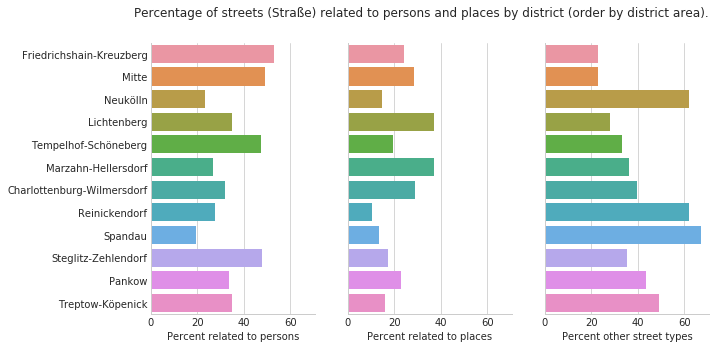

In [118]:
plot_street_counts_by_type(streets, areas)

Apart from a few exceptions (Lichtenberg, Marzahn-Hellersdorf and Charlottenburg-Wilmersdorf), we find that there are more streets dedicated to persons than to places. However, some districts (such as Neukölln, Reinickendorf and Spandau) have an extremely high amount of _other_ street types in comparison. Since Treptow-Köpenick, Spandau and Reinickendorf are some of the greener, outer districts of Berlin, one would assume to find more smaller street types (such as `Weg`) there, however Neukölln does not quite fit this assumption. 

We could dive deeper into this by determining and examining common suffixes as well; it could be interesting to see as well whether one would be able to predict a district given only a street name.

To investigate whether there is a correlation to the "greenness" of the district, we can obtain the number of mapped trees in these districts and compare them; for the outer districts we might expect a much higher count.

In [124]:
get_trees_in_region(berlin, district_bounds['Mitte'])

13429

In [125]:
get_trees_in_region(berlin, district_bounds['Neukölln'])

13536

In [126]:
get_trees_in_region(berlin, district_bounds['Spandau'])

2582

From the initial queries, this does not seem to be consistent. One reason for this could be that forests areas are not entirely mapped; it could also be, counter-intuitively, that the correlation is antiproportional.

## Further improvements

As stated already, one particular improvement for the investigation would be to extend `way` nodes with actual geocoordinates (rather than node references), so they become queryable directly. This leads to extreme data redundancy with increased disk and memory requirements, but could massively speed up queries. One particular concept and best practice of document oriented databases such as MongoDB is the denormalization of data in order to make every document self-contained; this is in contrast to relational databases, where strict normalization would be the goal. This could also benefit other queries, as e.g. train station platforms appear to be stored as polygons (`way`s) rather than `node`s.

If all queries target the differences between districts, splitting the data into separate district collections in the database directly would improve performance massively.
For other queries, such as "which is the route from district A to B with the highest number of trees per kilometer traveled", storing the data into a graph database might be more efficient.